### Notebook to Visualize the Impact of Normalization in Orthogonal Distance Fitting

This notebook demonstrates the subtle but important difference between normalizing the perpendicular vector `v_perp` when computing orthogonal distances in linear regression with uncertainties in both x and y.

By running the regression in both directions (y vs. x and x vs. y), we can show that **not normalizing `v_perp` yields consistent and reciprocal gradients**, whereas normalizing `v_perp` leads to mismatched results. This supports the approach used by Foreman-Mackey over the one from Hogg et al.


In [5]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# Covariance matrix assuming uncorrelated errors
def covariance_matrix(sigma_x, sigma_y):
    return np.array([[sigma_x**2, 0],
                     [0, sigma_y**2]])

# Model function
def model_function(x, m, b):
    return m * x + b

# Orthogonal distance calculation for a linear function
def orthogonal_distance(params, x, y, sigma_x, sigma_y, normalise_vperp = False):
    m, b = params
    y_model = model_function(x, m, b)  # Compute the y value from the model
    delta = y - y_model  # Distance between the data point and the curve
    S = covariance_matrix(sigma_x, sigma_y)  # Covariance matrix (uncorrelated errors)

    # Calculate perpendicular distance (same unit vector approach)
    # Unit vector orthogonal to the curve
    # Mathematical/Philosophical puzzle: how to normalise the uncertainties?
    # This is the prescription by Foreman-Mackey et al.:
    v_perp = np.array([m, -1])  # Unit vector orthogonal to the curve
    # This would be the description including the normalisation from Hogg et al.
    if normalise_vperp == True:
        v_perp = np.array([m, -1]) / np.sqrt(m**2 + 1)  

    sigma_perp = np.dot(np.dot(v_perp.T, S), v_perp)  # Projected uncertainty
    return delta**2 / sigma_perp  # Normalized distance

# Log-likelihood function for MCMC (based on orthogonal distance)
def log_likelihood(params, x, y, sigma_x, sigma_y, normalise_vperp = False):
    residuals = [orthogonal_distance(params, x[i], y[i], sigma_x[i], sigma_y[i], normalise_vperp) for i in range(len(x))]
    return -0.5 * np.sum(residuals)

# Define the log-prior function (uniform priors)
def log_prior(params):
    m, b = params
    if abs(m) >= 0 and abs(b) >= 0:  # Priors on m, and b
        return 0.0
    return -np.inf  # Return -inf outside the bounds

# Define the log-posterior function (log-prior + log-likelihood)
def log_posterior(params, x, y, sigma_x, sigma_y, normalise_vperp = False):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, sigma_x, sigma_y, normalise_vperp)

# Data from Table 1 (points 5 to 20)
si_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
mg_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_si = np.array([5, 9, 4, 4, 11, 7, 5, 5, 11, 7, 5, 5, 9, 8, 6, 5])
sigma_mg = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

def fit_y_from_x(initial_guess, x_data, sigma_x, y_data, sigma_y, normalise_vperp = False):
    """
    Independent of what x and y actually is, this function fits
    
    y = m * x + n
    
    and gives back the percentiles of m and n
    """
    
    # Set up the MCMC sampler
    ndim = 2  # Number of parameters (m, b)
    nwalkers = 50  # Number of MCMC walkers
    nsteps = 500  # Number of MCMC steps per walker
    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)  # Initial positions of walkers

    # Set up the MCMC sampler using emcee
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data, sigma_x, sigma_y, normalise_vperp))

    # Run the MCMC sampler
    sampler.run_mcmc(pos, nsteps, progress=True)

    # Extract the samples
    samples = sampler.get_chain(discard=100, thin=15, flat=True)

    # Corner plot to visualize the posterior distributions
    fig = corner.corner(samples, labels=["m", "b"], truths=initial_guess)
    plt.show()

    # Extract the best-fit parameters (median of posterior)
    m_mcmc, b_mcmc = np.median(samples, axis=0)
    print(f"Best-fit slope (m) from MCMC: {m_mcmc}")
    print(f"Best-fit intercept (b) from MCMC: {b_mcmc}")
    
    m_perc, n_perc = np.percentile(samples, q=[16,50,84], axis=0).T
    
    return(m_perc, n_perc)

def fit_and_plot(normalise_vperp = False):
    """
    normalise_vperp activates a switch in the normalisation of
    
    v_perp = np.array([m, -1])
    
    to
    
    v_perp = np.array([m, -1]) / np.sqrt(m**2 + 1)
    
    
    """

    # Si vs. Mg
    initial_guess = [2.25, 20]
    x_data  = si_data
    sigma_x = sigma_si
    y_data  = mg_data
    sigma_y = sigma_mg

    m_perc_si_mg, n_perc_si_mg = fit_y_from_x(initial_guess, x_data, sigma_x, y_data, sigma_y, normalise_vperp=normalise_vperp)

    # Mg vs. Si
    initial_guess = [1/2.25, -20/2.25]
    x_data  = mg_data
    sigma_x = sigma_mg
    y_data  = si_data
    sigma_y = sigma_si

    m_perc_mg_si, n_perc_mg_si = fit_y_from_x(initial_guess, x_data, sigma_x, y_data, sigma_y, normalise_vperp=normalise_vperp)

    print('Distribution of slope (and inverted slope) from fitting Mg(Si) and Si(Mg)')
    print(m_perc_si_mg, 1/m_perc_mg_si[::-1])

    f, gs = plt.subplots(1,2,figsize=(8,4))

    ax = gs[0]
    ax.errorbar(si_data, mg_data, xerr=sigma_si, yerr=sigma_mg, fmt='o', label='Data', capsize=3)

    # Plot best-fit function
    si_fit = np.linspace(min(si_data), max(si_data), 100)
    mg_fit = model_function(si_fit, m_perc_si_mg[1], n_perc_si_mg[1])
    ax.plot(si_fit, mg_fit, color='C1', label=f'Mg(Si) Fit:\nMg = {m_perc_si_mg[1]:.2f} Si + {n_perc_si_mg[1]:.2f}')

    mg_fit = np.linspace(min(mg_data), max(mg_data), 100)
    si_fit = model_function(mg_fit, m_perc_mg_si[1], n_perc_mg_si[1])
    ax.plot(si_fit, mg_fit, color='C3', label=f'Inverted Si(Mg) Fit:\nMg = {1/m_perc_mg_si[1]:.2f} Si + {-n_perc_mg_si[1]/m_perc_mg_si[1]:.2f}')
    ax.set_xlabel('Si',fontsize=15)
    ax.set_ylabel('Mg',fontsize=15)

    ax.legend()

    ax = gs[1]
    ax.errorbar(mg_data, si_data, xerr=sigma_mg, yerr=sigma_si, fmt='o', label='Data', capsize=3)

    # Plot best-fit function
    si_fit = np.linspace(min(si_data), max(si_data), 100)
    mg_fit = model_function(si_fit, m_perc_si_mg[1], n_perc_si_mg[1])
    ax.plot(mg_fit, si_fit, color='C1', label=f'Inverted Mg(Si) Fit:\nSi = {1/m_perc_si_mg[1]:.2f} Mg + {-n_perc_si_mg[1]/m_perc_si_mg[1]:.2f}')

    mg_fit = np.linspace(min(mg_data), max(mg_data), 100)
    si_fit = model_function(mg_fit, m_perc_mg_si[1], n_perc_mg_si[1])
    ax.plot(mg_fit, si_fit, color='C3', label=f'Inverted Si(Mg) Fit:\nSi = {m_perc_mg_si[1]:.2f} Mg + {n_perc_mg_si[1]:.2f}')
    ax.set_ylabel('Si',fontsize=15)
    ax.set_xlabel('Mg',fontsize=15)
    ax.legend()

    plt.tight_layout()
    if normalise_vperp == True:
        plt.savefig('fitting_xy_and_yx_norm.png',dpi=200,bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        plt.savefig('fitting_xy_and_yx.png',dpi=200,bbox_inches='tight')
        plt.show()
        plt.close()

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 123.87it/s]


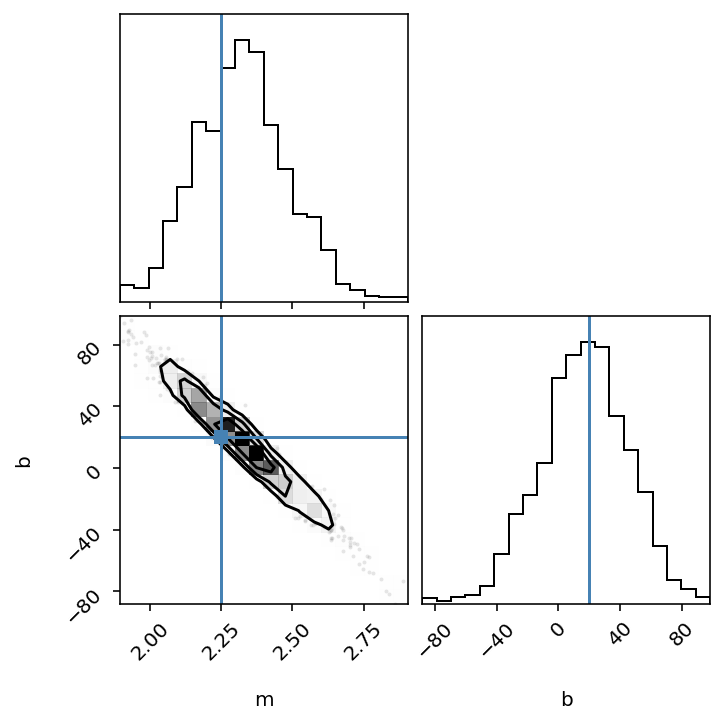

Best-fit slope (m) from MCMC: 2.3225941527311744
Best-fit intercept (b) from MCMC: 17.41196371635752


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 121.01it/s]


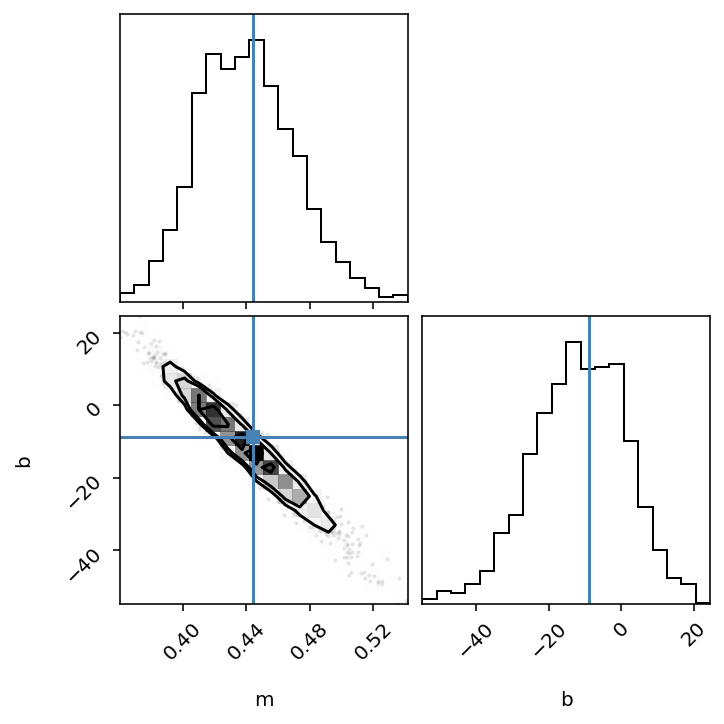

Best-fit slope (m) from MCMC: 0.4392046520566275
Best-fit intercept (b) from MCMC: -11.144276979879347
Distribution of slope (and inverted slope) from fitting Mg(Si) and Si(Mg)
[2.16039889 2.32259415 2.48487459] [2.12580342 2.27684291 2.43426209]


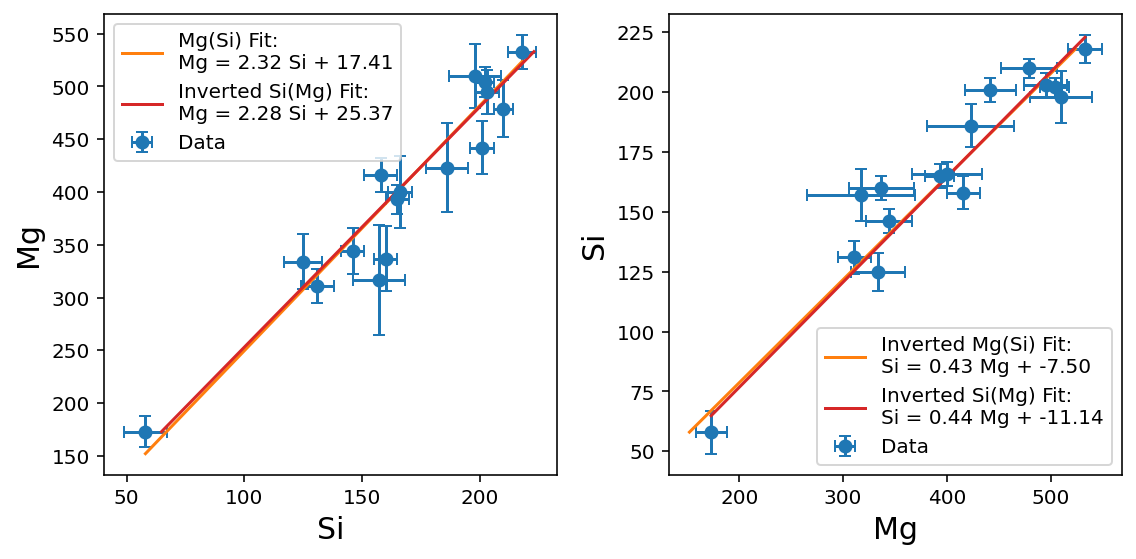

In [6]:
fit_and_plot(normalise_vperp = False)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 90.73it/s]


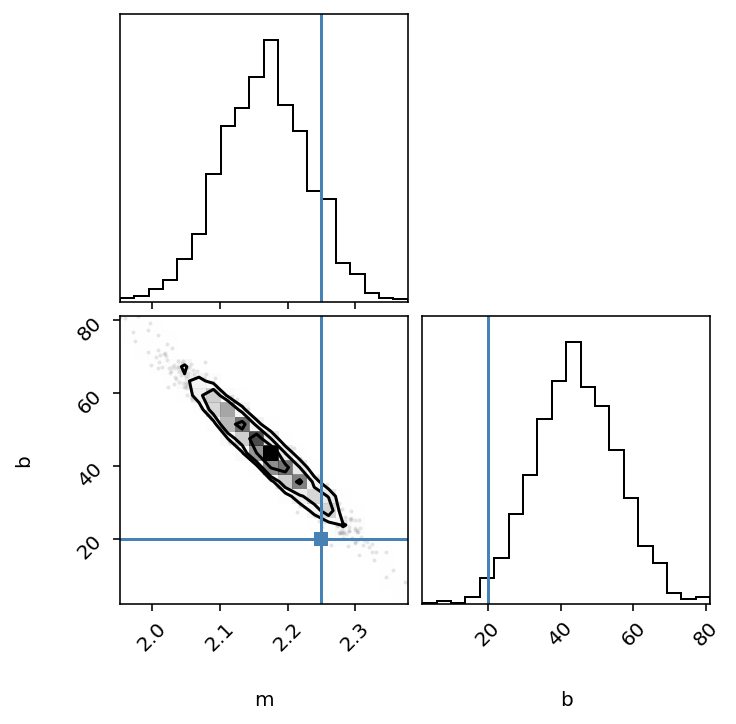

Best-fit slope (m) from MCMC: 2.1665649357358743
Best-fit intercept (b) from MCMC: 44.433878703849345


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 90.30it/s]


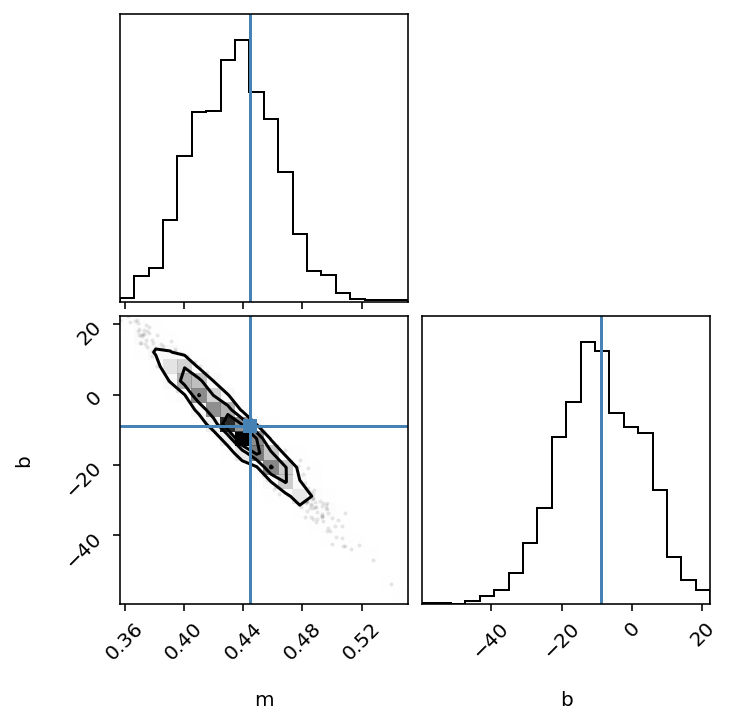

Best-fit slope (m) from MCMC: 0.4347422048661779
Best-fit intercept (b) from MCMC: -9.46174746249984
Distribution of slope (and inverted slope) from fitting Mg(Si) and Si(Mg)
[2.10191532 2.16656494 2.23107737] [2.16180488 2.30021376 2.46542881]


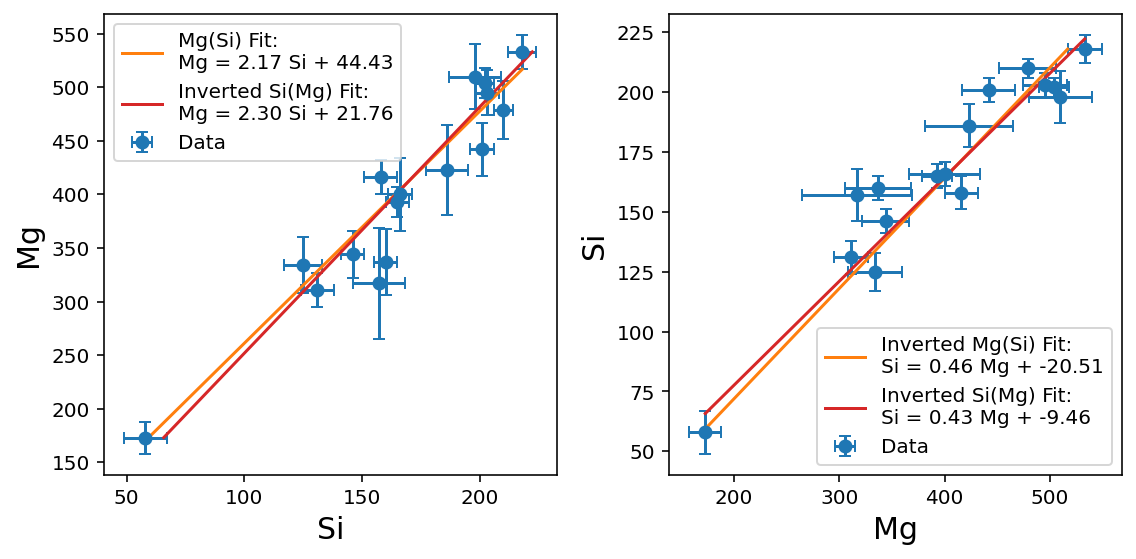

In [7]:
fit_and_plot(normalise_vperp = True)